In [1]:
from PORTAL import DualGuidePORTAL
import pandas as pd
import numpy as np
from scipy.cluster.hierarchy import linkage, optimal_leaf_ordering, dendrogram
from scipy.spatial.distance import squareform
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LinearSegmentedColormap

In [2]:
import mkl

print(f"Current MKL threads: {mkl.get_max_threads()}")

Current MKL threads: 16


In [3]:
cdict = {'red':((0.0,0.125,0.125),
                (0.5,0.0,0.0),
                (1.0,0.957,0.957)),
        'green':((0.0,0.713,0.713),
                (0.5,0.0,0.0),
                (1.0,0.918,0.918)),
        'blue': ((0.0,0.886,0.886),
                (0.5,0.0,0.0),
                (1.0,0.094,0.094))}
blue_yellow = LinearSegmentedColormap('BlueYellow',cdict)
blue_yellow.set_bad((.9, .9, .9, 1.0))
matplotlib.colormaps.register(cmap=blue_yellow)

In [4]:
sns.set_context('paper')
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = ["Arial"]
plt.rcParams['legend.fontsize'] = 12
plt.rcParams['legend.title_fontsize'] = 14

In [5]:
umi_filepath = "/data1/normantm/angel/Pscreen_data/single_cell_screen/UMI_counts.csv"

In [6]:
umi_df = pd.read_csv(umi_filepath)
umi_df["column"] = umi_df["sample"].astype(str) + "_" + umi_df.well.str[1:]

In [7]:
pseudobulk_umi_df = umi_df.groupby(
    ["p1_identity", "p2_identity", "barcode_mapped", "sample", "column"]
)[["UMI_reporter", "UMI_identity"]].sum().reset_index().rename(columns={"sample": "rep"})

In [8]:
pseudobulk_screen = DualGuidePORTAL(pseudobulk_umi_df, sample_columns=["column", "rep"])
pseudobulk_screen.run_standard_analysis(gi_kind="joint")

Generated guide IDs: 93 genes with 100 guides
Step 1/12: Filtering overrepresented lineages...
Applied thresholds: repr1=0.0500, repr2=0.0500
Step 2/12: Setting controls...
Step 3/12: Log transforming UMIs...
Step 4/12: Formatting sample columns...
Step 5/12: Regressing reporter...
Coefficients: [[ 0.06215621 -0.00612118  0.00612118 -0.00626476  0.00163152 -0.00148794
   0.00402166 -0.00831875  0.01041827]]
Intercept: [3.12094733]
R^2 score: 0.11122039678584994
Step 6/12: Regressing identity (Poisson)...
Step 7/12: Calculating summary statistics...
Step 8/12: Calculating activity matrices...
Step 9/12: Skipping PCP decomposition...
Step 10/12: Saving guide activities...
PCP activities not calculated
'DualGuidePORTAL' object has no attribute 'reporter_pcp_results'
Step 11/12: Calculating genetic interactions...
PCP interactions not calculated
Step 12/12: Clustering genetic interactions...
Clustering not performed for PCP interactions

Analysis complete!


In [9]:
def plot_half_matrices(df1, df2, linkage_matrix, 
                      figsize=(12, 12), cmap='viridis', cmap_lower=None,
                      dendrogram_color='black', dendrogram_linewidth=0.5,
                      titles=None, color_scale=2, ticklabels=False):
    """
    Plots two symmetric matrices in one plot with optional different colormaps.
    - Upper triangle + diagonal: df1 values
    - Lower triangle: df2 values
    
    Args:
        cmap: Colormap for upper triangle (and lower if cmap_lower is None)
        cmap_lower: Optional separate colormap for lower triangle
    """
    
    if cmap_lower is None:
        cmap_lower = cmap
    
    order = dendrogram(linkage_matrix, no_plot=True)['leaves']
    df1_ordered = df1.iloc[order, order]
    df2_ordered = df2.iloc[order, order]
    df1_ordered = df1_ordered / df1_ordered.stack().std()
    df2_ordered = df2_ordered / df2_ordered.stack().std()
    
    
    n = len(df1_ordered)
    
    upper_data = np.full((n, n), np.nan)
    lower_data = np.full((n, n), np.nan)
    
    upper_indices = np.triu_indices(n, 1)
    upper_data[upper_indices] = df1_ordered.values[upper_indices]
    
    lower_indices = np.tril_indices(n, -1)
    lower_data[lower_indices] = df2_ordered.values[lower_indices]
    
    fig = plt.figure(figsize=figsize)
    gs = GridSpec(2, 2, figure=fig,
                 height_ratios=[0.1, 0.9],
                 width_ratios=[0.1, 0.9],
                 hspace=0.005, wspace=0.005)
    
    ax_row_dend = fig.add_subplot(gs[1, 0])
    ax_col_dend = fig.add_subplot(gs[0, 1])
    ax_heatmap = fig.add_subplot(gs[1, 1])
    
    with plt.rc_context({'lines.linewidth': dendrogram_linewidth}):
        dendrogram(linkage_matrix, orientation='left', ax=ax_row_dend, 
                   color_threshold=0, link_color_func=lambda x: dendrogram_color)
        dendrogram(linkage_matrix, ax=ax_col_dend,
                   color_threshold=0, link_color_func=lambda x: dendrogram_color)
    ax_row_dend.axis('off')
    ax_col_dend.axis('off')
    
    vmin, vmax = -color_scale, color_scale
    
    # Plot upper triangle
    im_upper = ax_heatmap.imshow(upper_data, cmap=cmap,
                                 vmin=vmin,
                                 vmax=vmax,
                                 aspect='auto', interpolation='nearest', origin='upper')
    
    # Plot lower triangle on top
    im_lower = ax_heatmap.imshow(lower_data, cmap=cmap_lower,
                                 vmin=vmin, 
                                 vmax=vmax,
                                 aspect='auto', interpolation='nearest', origin='upper')
    
    ax_heatmap.set_xlim(-0.5, n - 0.5)
    ax_heatmap.set_ylim(n - 0.5, -0.5)
    ax_heatmap.set_aspect('equal', adjustable='box')

    for spine in ax_heatmap.spines.values():
        spine.set_visible(False)
    
    if ticklabels:
        ax_heatmap.set_xticks(range(n))
        ax_heatmap.set_yticks(range(n))
        ax_heatmap.set_xticklabels(df1_ordered.columns, rotation=90, ha='center', fontsize=6)
        ax_heatmap.set_yticklabels(df1_ordered.index, rotation=0, ha='left', fontsize=6)
        ax_heatmap.yaxis.tick_right()
        ax_heatmap.yaxis.set_label_position('right')
    else:
        ax_heatmap.set_xticks([])
        ax_heatmap.set_yticks([])
    
    if titles:
        ax_col_dend.set_title(f"{titles[0]} (Upper) | {titles[1]} (Lower)", 
                            pad=20, fontsize=12)
    
    # Add colorbars
    if cmap == cmap_lower:
        cbar_ax = fig.add_axes([0.14, 0.81, 0.015, 0.06])
        cbar = plt.colorbar(im_upper, cax=cbar_ax, orientation='vertical')
        cbar.ax.tick_params(labelsize=8, width=0.5, length=2)
        for spine in cbar_ax.spines.values():
            spine.set_linewidth(0.5)
    else:
        cbar_ax_upper = fig.add_axes([0.14, 0.88, 0.015, 0.05])
        cbar_ax_lower = fig.add_axes([0.14, 0.81, 0.015, 0.05])
        
        cbar_upper = plt.colorbar(im_upper, cax=cbar_ax_upper, orientation='vertical')
        cbar_upper.ax.tick_params(labelsize=7, width=0.5, length=2)
        #cbar_upper.set_label('Upper', fontsize=8)
        
        cbar_lower = plt.colorbar(im_lower, cax=cbar_ax_lower, orientation='vertical')
        cbar_lower.ax.tick_params(labelsize=7, width=0.5, length=2)
        #cbar_lower.set_label('Lower', fontsize=8)
        
        for spine in cbar_ax_upper.spines.values():
            spine.set_linewidth(0.5)
        for spine in cbar_ax_lower.spines.values():
            spine.set_linewidth(0.5)
    
    return fig

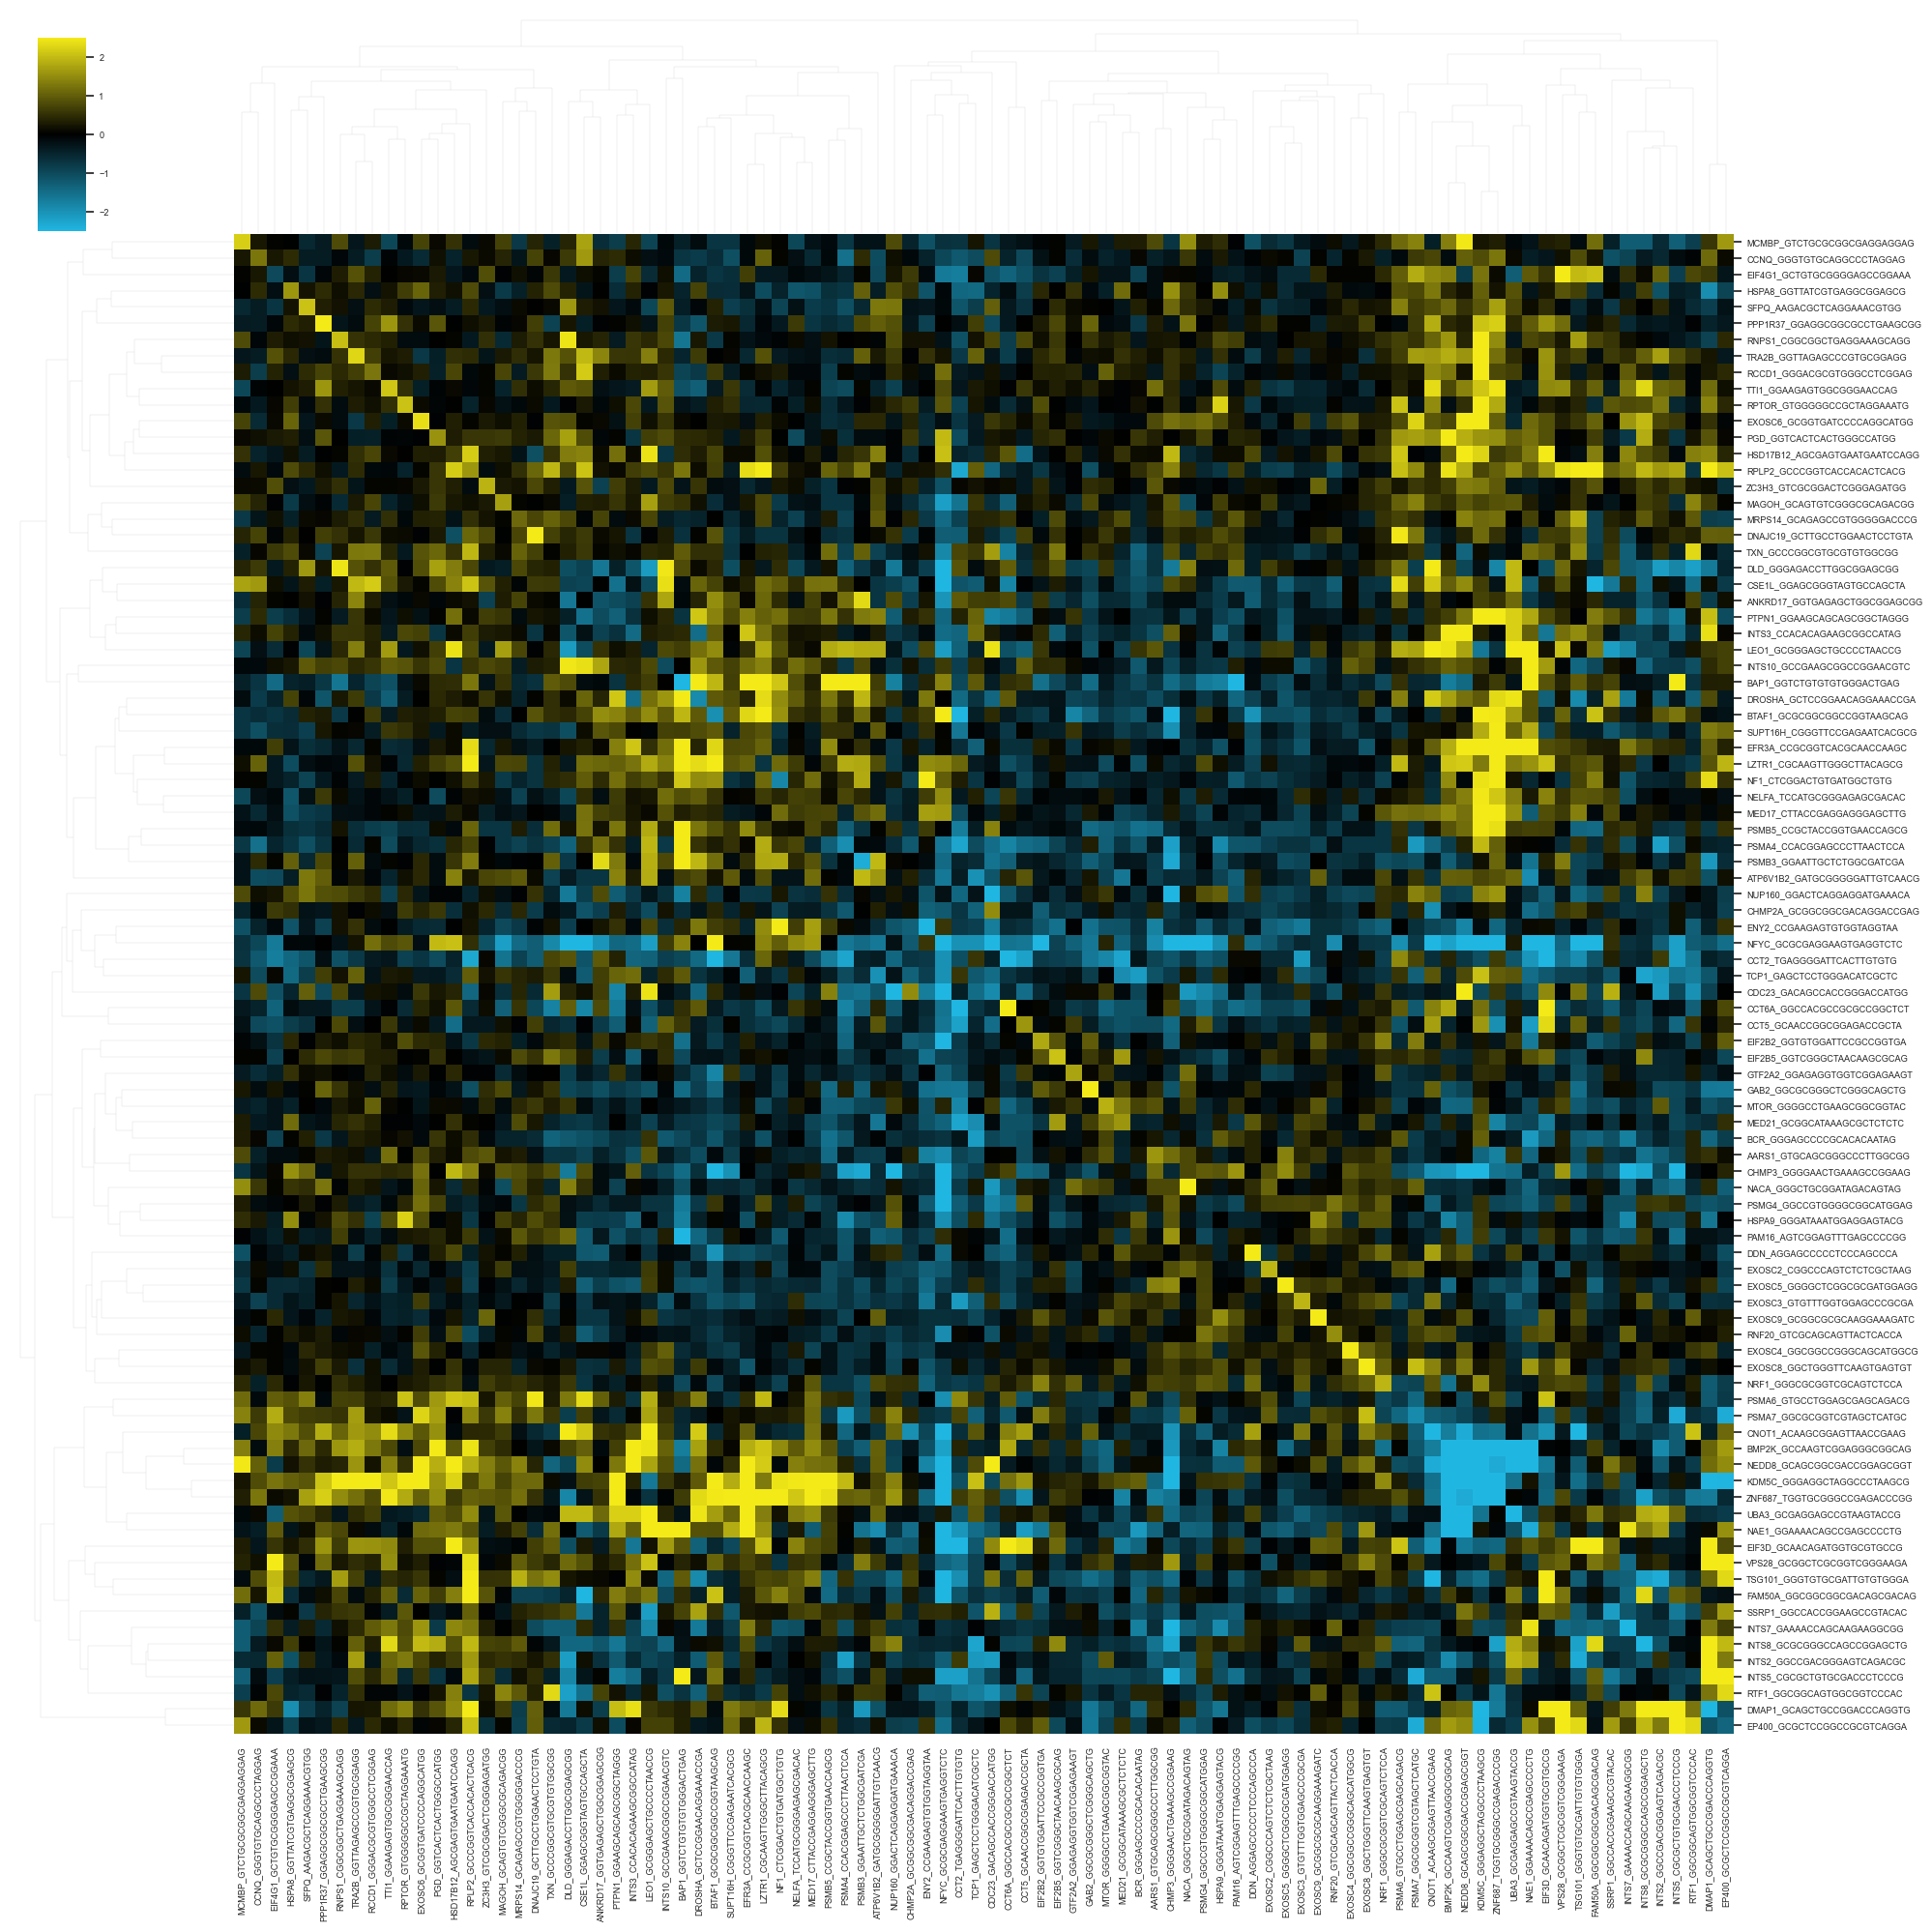

In [10]:
sns.set(font_scale=0.6, style="white")
delta = pseudobulk_screen.z_reporter_GI
Z = pseudobulk_screen.reporter_Z
g = sns.clustermap(delta,
                   cmap='BlueYellow', 
                   row_linkage=Z,
                   col_linkage=Z, 
                   #xticklabels=False, yticklabels=False,
                   center=0,  figsize=(20, 20),
                   dendrogram_ratio=0.13, cbar_pos=(0.02, 0.88, 0.025, 0.1),
                   vmin=-2.5,
                   vmax=2.5,
                   rasterized=True, tree_kws=dict(linewidths=0.05))

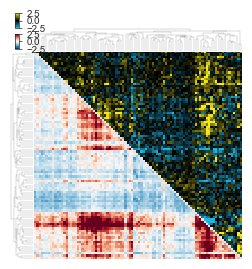

In [11]:
fig = plot_half_matrices(pseudobulk_screen.z_reporter_GI, pseudobulk_screen.reporter_avg_guide_matrix, pseudobulk_screen.reporter_Z, 
                        cmap='BlueYellow', cmap_lower='RdBu_r', dendrogram_linewidth=0.1,
                         color_scale=2.5, ticklabels=False,
                        figsize=(3, 3))
# fig.savefig("single_cell_GI_final.svg", bbox_inches="tight")

In [12]:
screen = DualGuidePORTAL(umi_df.rename(columns={"sample": "rep"}),
                          sample_columns=["column", "well", "rep"])

Generated guide IDs: 93 genes with 100 guides


In [13]:
screen.filter_overrepresented_lineages()
screen.set_control(control_prefix="non")
screen.log_transform_UMIs(pseudocount=1)

Applied thresholds: repr1=0.0500, repr2=0.0500


In [14]:
def add_canonical_pert_vectorized(df):
    use_original_order = df['p1_identity'] <= df['p2_identity']
    
    canonical_pert = np.where(
        use_original_order,
        df['p1_identity'] + '+' + df['p2_identity'],
        df['p2_identity'] + '+' + df['p1_identity']
    )
    
    return canonical_pert

In [15]:
def visualize_perturbation_lineages(df, 
                                    canonical_pert, 
                                    lineage_cols, 
                                    value_col, 
                                    min_lineage_size=11, 
                                    top_pct=50,
                                    figsize=(20, 5)):
    df_plot = df.copy()
    df_plot['lineage_id'] = (df_plot[lineage_cols[0]].astype(str) + '_' + 
                             df_plot[lineage_cols[1]].astype(str) + '_' + 
                             df_plot[lineage_cols[2]].astype(str) + '_' + 
                             df_plot[lineage_cols[3]].astype(str))
    df_plot['canonical_pert'] = add_canonical_pert_vectorized(df_plot)
    
    pert_data = df_plot[df_plot['canonical_pert'] == canonical_pert]
    
    lineage_counts = pert_data['lineage_id'].value_counts()
    adequate_lineages = lineage_counts[lineage_counts >= min_lineage_size].index
    pert_data = pert_data[pert_data['lineage_id'].isin(adequate_lineages)]
    
    if pert_data.empty:
        print(f"No lineages with >= {min_lineage_size} cells for '{canonical_pert}'")
        return
    
    # Calculate stats for ALL lineages
    lineage_means = pert_data.groupby('lineage_id')[value_col].mean().sort_values()
    mean_expr_all = pert_data[value_col].mean()
    n_lineages_all = len(lineage_means)
    
    # Keep only top X% of lineages for plotting
    n_top = int(n_lineages_all * (top_pct / 100))
    top_lineages = lineage_means.iloc[-n_top:].index  # Take the highest X%
    pert_data_plot = pert_data[pert_data['lineage_id'].isin(top_lineages)]
    
    # Recompute lineage_means for plotting (only top X%)
    lineage_means_plot = pert_data_plot.groupby('lineage_id')[value_col].mean().sort_values()
    
    pert_data_plot['lineage_ordered'] = pd.Categorical(
        pert_data_plot['lineage_id'], categories=lineage_means_plot.index, ordered=True
    )
    
    fig, ax = plt.subplots(figsize=figsize)
    
    sns.boxplot(data=pert_data_plot, x='lineage_ordered', y=value_col, ax=ax, linewidth=0.3,
                color='#c16e71', width=0.9, fliersize=0)
    sns.stripplot(data=pert_data_plot, x='lineage_ordered', y=value_col, ax=ax,
                  jitter=0.2, size=1, color='black', alpha=0.2)
    
    # Helper to format stats, returning 'N/A' if a value is missing/NaN
    def format_stat(value, fmt):
        if pd.isna(value):
            return 'N/A'
        return f"{value:{fmt}}"
    g1 = canonical_pert.split("+")[0].split("_")[0]
    g2 = canonical_pert.split("+")[1].split("_")[0]

    if g1 == 'non-targeting' and g2 == 'non-targeting':
        pert_name = "control"
    else:
        pert_name = f'{g1}+{g2}'
    
    # Use stats from ALL lineages
    ax.set_title(f'Perturbation: {pert_name} | Mean: {mean_expr_all:.2f} | Total lineages: {n_lineages_all}', fontsize=16)
    ax.set_xticks([])
    ax.set_xlabel(f'Top {top_pct}% Lineages (ordered by mean)', fontsize=14)
    ax.set_ylabel(value_col, fontsize=14)
    # ax.set_yscale("log", base=2)
    plt.ylim(None, 4)
    for spine in ax.spines.values():
        spine.set_visible(False)
    
    plt.tight_layout()
    plt.show()
    return fig

In [16]:
lineage_cols = ['p1_identity', 'p2_identity', 'barcode_mapped', 'rep']

/tmp/ipykernel_3965963/769641246.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pert_data_plot['lineage_ordered'] = pd.Categorical(


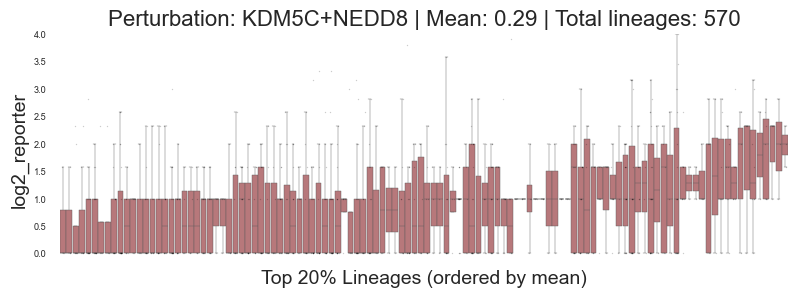

In [17]:
fig = visualize_perturbation_lineages(
    df=screen.filtered_umi_df,
    canonical_pert="KDM5C_GGGAGGCTAGGCCCTAAGCG+NEDD8_GCAGCGGCGACCGGAGCGGT",
    lineage_cols=lineage_cols,
    value_col='log2_reporter',
    min_lineage_size=2,
    top_pct=20,
    figsize=(8, 3)
)
# fig.savefig("single_cell_example_KDM5C_NEDD8_log2_top20pct.svg", bbox_inches="tight")

/tmp/ipykernel_3965963/769641246.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pert_data_plot['lineage_ordered'] = pd.Categorical(


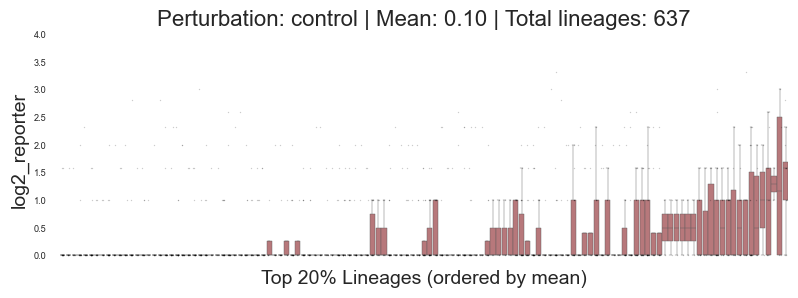

In [18]:
fig = visualize_perturbation_lineages(
    df=screen.filtered_umi_df,
    canonical_pert="non-targeting_00347_GACAGGATCAGTGAGCTAAA+non-targeting_03346_GAGGCGCCTTTAATTTGCGT",
    lineage_cols=lineage_cols,
    value_col='log2_reporter',
    min_lineage_size=2,
    top_pct=20,
    figsize=(8, 3)
)
# fig.savefig("single_cell_example_control_log2_top20pct.svg", bbox_inches="tight")

/tmp/ipykernel_3965963/769641246.py:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pert_data_plot['lineage_ordered'] = pd.Categorical(


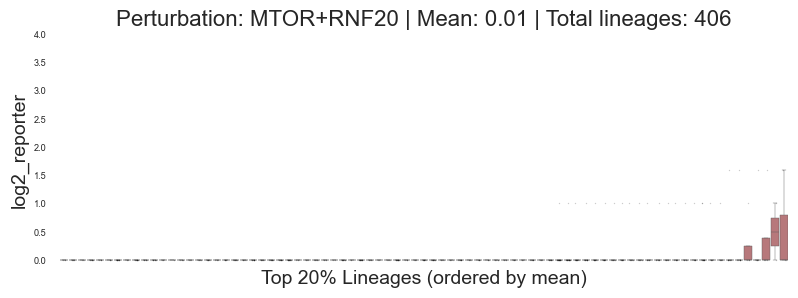

In [19]:
fig = visualize_perturbation_lineages(
    df=screen.filtered_umi_df,
    canonical_pert="MTOR_GGGGCCTGAAGCGGCGGTAC+RNF20_GTCGCAGCAGTTACTCACCA",
    lineage_cols=lineage_cols,
    value_col='log2_reporter',
    min_lineage_size=2,
    top_pct=20,
    figsize=(8, 3)
)
# fig.savefig("single_cell_example_MTOR_RNF20_log2_top20pct.svg", bbox_inches="tight")